# Определение актуального тарифа для компании "Мегалайн"

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Шаг 1. Открыть файл с данными и изучить общую информацию
### Шаг 2. Подготоветь данные
### Шаг 3. Проанализировать данные
### Шаг 4. Проверить гипотезы
### Шаг 5. Написать общий вывод

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
#users.sample(10)
#users.info() #поменять тип данных reg_date
#calls.sample(10)
#calls.info() #поменять тип данных
#messages.sample(10)
#messages.info() #поменять тип данных message_date
#internet.sample(10) #cтолбец unnamedL0 удалить
#internet.info() #поменять тип данных session_date
#tariffs.sample(2)
#tariffs.info() #все в порядке

### Вывод

Мы имеем 5 таблиц: пользователей, звонков, сообщений, интернета, тарифов. NaN, которые не будем заменять, обнаружены в таблице users в столбце churn_date, т.к. они не заканчивали пользование выбранным тарифом. Критических ошибок на первый взгляд не замечено.

In [3]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d') #заменяем на дату
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
del internet['Unnamed: 0']

Следующим шагом рассмотрим нулевые значения в звонках и интернет-трафике

Text(0.5, 1.0, 'Зависимость количества нулевых значений от общего числа звонков за каждый месяц')

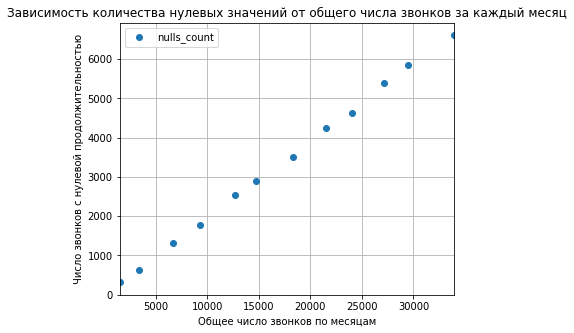

In [4]:
calls['duration'].value_counts() #имеем 39613 пропущенных звонков
calls['month'] = calls['call_date'].dt.month #добавляем столбец месяцов

calls.loc[calls['duration'] == 0, 'nulls_count'] = 1
null_calls = calls.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_calls['null_ratio'] = round(null_calls['nulls_count'] / null_calls['id'])
#строим график для кол-ва пропущенных звонков от общего числа за каждый месяц
null_calls.plot(x='id', y= 'nulls_count', style='o', grid=True, figsize=(6, 5))
plt.xlabel('Общее число звонков по месяцам')
plt.ylabel('Число звонков с нулевой продолжительностью')
plt.title('Зависимость количества нулевых значений от общего числа звонков за каждый месяц')

Так как, глядя на график, можно заметить линейную зависимость, тогда логично заменить все значения в большую сторону, подобая правилам тарифов, а нулевые значения заменить на 1. 

Я предполагаю, что нулевые значения могут появится из-за того, что звонки являются пропущенными, либо их округляют в меньшую сторону. Так или иначе, чтобы удовлетворять правилам тарифа мы округляем или заменяем нули на 1. 

In [5]:
calls['duration'] = calls['duration'].apply(np.ceil) 
calls.loc[calls['duration'] == 0, 'duration'] = 1

Text(0.5, 1.0, 'Зависимость количества нулевых значений от общего числа интернет-сессий за каждый месяц')

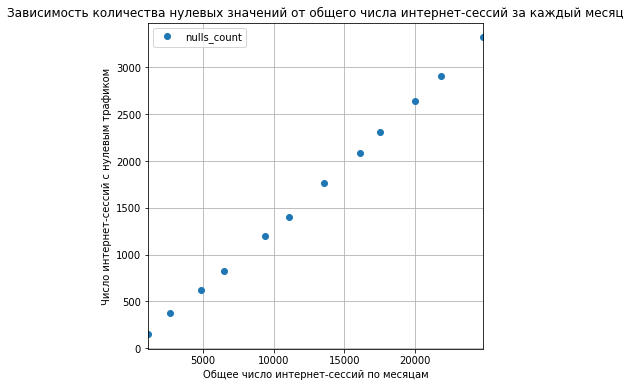

In [6]:
internet['mb_used'].value_counts() #имеем 19598 0-ых 
internet['month'] = internet['session_date'].dt.month

internet.loc[internet['mb_used'] == 0, 'nulls_count'] = 1
null_mb = internet.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_mb['null_ratio'] = round(null_mb['nulls_count'] / null_mb['id'])
#строим график для кол-ва нулевых значений от общего числа за каждый месяц

null_mb.plot(x='id', y= 'nulls_count', style='o', grid=True, figsize=(6, 6))
plt.xlabel('Общее число интернет-сессий по месяцам')
plt.ylabel('Число интернет-сессий с нулевым трафиком')
plt.title('Зависимость количества нулевых значений от общего числа интернет-сессий за каждый месяц')

Так как картина максимально схожа с прошлым примером, можем сделать абсолютно аналогичный вывод.

In [7]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1
internet['mb_used'].value_counts()

1.0       19700
333.0       231
382.0       228
377.0       224
334.0       222
          ...  
1456.0        1
1525.0        1
1522.0        1
1394.0        1
1534.0        1
Name: mb_used, Length: 1423, dtype: int64

In [8]:
users['full_name'] = users['first_name'] + users['last_name'] #полное имя клиента

#cтроим таблицу для каждого пользователя по звонкам
calls_temp = calls.merge(users, on='user_id', how='inner')
calls_grouped = calls_temp.pivot_table(values=['full_name', 'duration'], index=['user_id', 'month'], aggfunc={'full_name': 'count', 'duration': 'sum'})
calls_grouped.columns = ['duration', 'calls']

#cтроим таблицу для каждого пользователя по cообщениям
messages['month'] = messages['message_date'].dt.month
messages_temp = messages.merge(users, on='user_id', how='inner')
messages_grouped = messages_temp.pivot_table(values='full_name', 
                       index=['user_id', 'month'], 
                       aggfunc={'full_name': 'count'})
messages_grouped.columns = ['messages']

#cтроим таблицу для каждого пользователя по интернет-трафику
internet_temp = internet.merge(users, on='user_id', how='inner')
internet_grouped = internet_temp.pivot_table(values='mb_used', 
                       index=['user_id', 'month'], 
                       aggfunc={'mb_used': 'sum'})
internet_grouped.columns = ['mb_used']

#Объединим все три таблицы
grouped_data = calls_grouped.merge(messages_grouped, on = ['user_id', 'month'], how='outer')
grouped_data = grouped_data.merge(internet_grouped, on = ['user_id', 'month'], how='outer')
grouped_data.head(15)

duration  calls  messages  mb_used
user_id month                                    
1000    5         164.0   22.0      22.0   2257.0
        6         187.0   43.0      60.0  23262.0
        7         346.0   47.0      75.0  14017.0
        8         418.0   52.0      81.0  14072.0
        9         478.0   58.0      57.0  14583.0
        10        363.0   57.0      73.0  14717.0
        11        344.0   43.0      58.0  14769.0
        12        341.0   46.0      70.0   9829.0
1001    11        444.0   59.0       NaN  18460.0
        12        430.0   63.0       NaN  14059.0
1002    6         118.0   15.0       4.0  10878.0
        7         219.0   26.0      11.0  17615.0
        8         294.0   42.0      13.0  20357.0
        9         217.0   36.0       4.0  16724.0
        10        221.0   33.0      10.0  13913.0

Следующим шагом посчитаем помесячную выручку, пользуясь начальным условием.

Пропуски заменены на 0, т.к. скорее всего, пользователи не пользовались услугами тарифа в данный период времени, а также, чтобы пропущенные значения, которые заменены, не влияли на наш анализ.


In [9]:
# пропущенные значения заменяем на нули
grouped_data.loc[grouped_data['duration'].isna(), 'duration'] = 0
grouped_data.loc[grouped_data['messages'].isna(), 'messages'] = 0
grouped_data.loc[grouped_data['mb_used'].isna(), 'mb_used'] = 0

# добавим наименование используемого тарифа для каждого пользователя
for user in grouped_data.index:
    grouped_data.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']

# функция подсчета выручки с каждого пользователя в месяц
def det_revenue(row):
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
    duration = row['duration']
    calls = row['calls']
    
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[0, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[0, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[0, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[0, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[1, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[1, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[1, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[1, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )

grouped_data['revenue'] = grouped_data.apply(det_revenue, axis=1)
grouped_data.sample(20)

,,duration,calls,messages,mb_used,tariff,revenue
user_id,month,,,,,,
1365,11,639.0,91.0,46.0,24000.0,smart,2654.500000
1052,8,728.0,96.0,111.0,17452.0,smart,1825.593750
1208,3,98.0,18.0,0.0,4065.0,ultra,1950.000000
1259,11,481.0,74.0,157.0,10426.0,ultra,1950.000000
1308,7,183.0,29.0,33.0,16590.0,smart,790.234375
1313,10,285.0,39.0,5.0,5223.0,smart,550.000000
1126,4,702.0,87.0,6.0,27211.0,ultra,1950.000000
1152,5,349.0,41.0,0.0,27600.0,ultra,1950.000000
1057,11,665.0,87.0,30.0,20498.0,ultra,1950.000000


### Вывод

В данном пункте мы закончили предобработку данных, а также вычислили следующие расчетные значения для каждого пользователя: кол-во сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам и объем израсходованного интернет-трафика по месяцам. А в итоге посчитали помесячную выручку для каждого пользователя, соответствующую тарифам.

In [10]:
#Посчитаем, сколько в среднем каждому пользователю требуется минут, сообщений и мегабайт в месяц
medians = grouped_data.pivot_table(index='user_id', values=['duration', 'messages', 'mb_used', 'revenue'], aggfunc='median')
for user_id in users['user_id']:
    medians.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']
medians.head(15)

,duration,mb_used,messages,revenue,tariff
user_id,,,,,
1000,345.0,14327.5,65.0,1950.000000,ultra
1001,437.0,16259.5,0.0,852.734375,smart
1002,221.0,17615.0,11.0,990.429688,smart
1003,844.0,11369.0,83.0,1950.000000,ultra
1004,136.5,17831.0,154.5,1950.000000,ultra
1005,609.5,7846.5,49.0,884.500000,smart
1006,365.0,15554.0,0.0,587.890625,smart
1007,490.0,14451.0,26.0,881.843750,smart
1008,350.0,13243.0,56.0,568.000000,smart


In [11]:
#Находим медиану, дисперсию и стандартное отклонение:
medians.dropna(subset=['duration'], inplace=True)
desc_stat = grouped_data.pivot_table(index=['tariff'], values=['duration', 'mb_used', 'messages'], 
                    aggfunc={'duration': [np.median, np.var, np.std], 
                             'mb_used': [np.median, np.var, np.std], 
                             'messages': [np.median, np.var, np.std]})
desc_stat

duration                             mb_used                \
         median         std            var   median           std   
tariff                                                              
smart     435.0  194.871174   37974.774628  16540.0   5879.795158   
ultra     532.0  325.738740  106105.726823  19324.0  10097.107541   

                     messages                          
                 var   median        std          var  
tariff                                                 
smart   3.457199e+07     28.0  28.227876   796.812958  
ultra   1.019516e+08     38.0  47.804457  2285.266143

In [19]:
# Код ревьюера
medians.pivot_table(index=['tariff'], values=['duration', 'mb_used', 'messages'], 
                    aggfunc={'duration': [np.median, np.var, np.std], 
                             'mb_used': [np.median, np.var, np.std], 
                             'messages': [np.median, np.var, np.std]})

duration                             mb_used               \
         median         std           var    median          std   
tariff                                                             
smart     453.0  164.614327  27097.876586  16955.00  4181.498288   
ultra     550.5  311.491491  97026.949014  19751.75  8901.975727   

                     messages                          
                 var   median        std          var  
tariff                                                 
smart   1.748493e+07     28.5  28.010653   784.596662  
ultra   7.924517e+07     47.5  49.236809  2424.263318

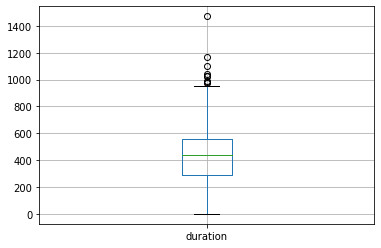

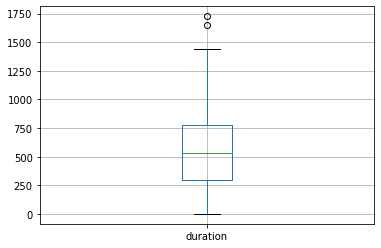

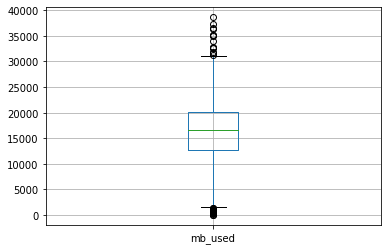

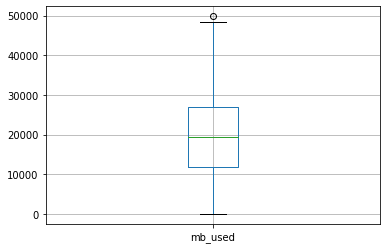

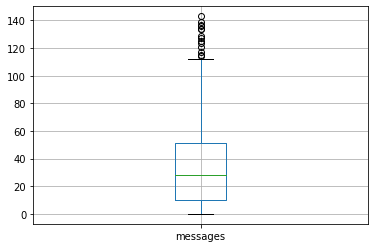

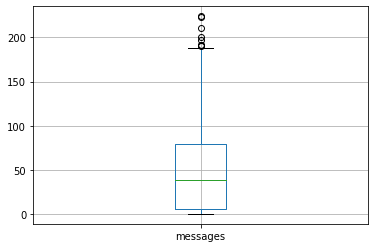

In [12]:
smart = grouped_data[grouped_data['tariff'] == 'smart']
ultra = grouped_data[grouped_data['tariff'] == 'ultra']

for column in ['duration', 'mb_used', 'messages']: 
    smart.plot(x="tariff", y=column, kind="box", grid = True)
    plt.show()
    ultra.plot(x="tariff", y=column, kind="box", grid = True)
    plt.show()

Можно заметить, что минуты разговора, кол-во сообщений и объем интернет-трафика по тарифу Ультра имеет большую дисперсию по сравнению с тарифом Смарт, а также медианные значения имеют смещение в большую сторону. 

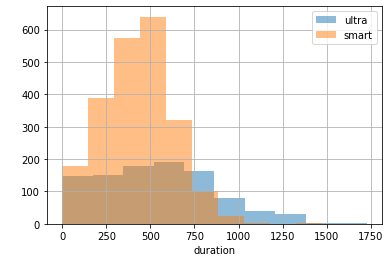

In [13]:
for tariff in ['ultra', 'smart']:
    grouped_data.query('tariff == @tariff')['duration'].plot( kind = 'hist', alpha = 0.5, grid = True)
plt.xlabel('duration')
plt.ylabel(' ')
plt.legend(['ultra', 'smart'])

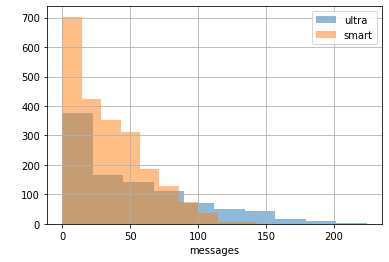

In [14]:
for tariff in ['ultra', 'smart']:
    grouped_data.query('tariff == @tariff')['messages'].plot(kind = 'hist', alpha = 0.5, grid = True)
plt.xlabel('messages')
plt.ylabel(' ')
plt.legend(['ultra', 'smart'])

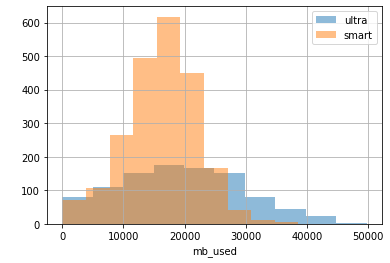

In [15]:
for tariff in ['ultra', 'smart']:
    grouped_data.query('tariff == @tariff')['mb_used'].plot(kind = 'hist', alpha = 0.5, grid = True)
plt.xlabel('mb_used')
plt.ylabel(' ')
plt.legend(['ultra', 'smart'])

### Вывод

В данном пункте мы нашли, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Также посчитали среднее количество, дисперсию и стандартное отклонение и в конце концов построили гистограммы. Смотря на гистограммы, можно заметить, что дисперсия по тарифу Ультра больше, чем у пользователей с тарифом Смарт по соотвествующим показателям, т.е. по длительности разговора, кол-ву сообщений и объему израссходованного объема интернета. И очевидно, что пользователей с тарифом Смарт в разы больше.

#### Проверим следующую гипотезу
##### H0 - cредняя выручка пользователей тарифа Ультра совпадает со средней выручкой тарифа Смарт;
##### H1 - средняя выручка пользователей тарифа Ультра отличается от средней выручки тарифа Смарт

In [16]:
# Возьмем общепринятое значения "альфа" 1%, т.к. мы имеем довольно крупную выборку.
#grouped_data.pivot_table(index='tariff', values='revenue', aggfunc='median')
ultra = grouped_data.query('tariff == "ultra"')['revenue']
smart = grouped_data.query('tariff == "smart"')['revenue']

alpha = .01

results = st.ttest_ind(ultra, smart, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.4535744400867116e-281
Отвергаем нулевую гипотезу


Изначально можно заметить, что средние значения выручки по обоим тарифам различаются больше, чем в два раза. А также, после проверки нашей мы подтвердили, что они различаются.

#### Проверим следующую гипотезу
##### H0 - средняя выручка пользователей из Москвы совпадает со средней выручкой пользователей из других регионов;
##### H1 - средняя выручка пользователей из Москвы отличается от средней выручки пользователей из других регионов

In [17]:
for user in grouped_data.index:
    grouped_data.loc[user, 'city'] = users.loc[user[0]-1000, 'city']

moscow = grouped_data.query('city == "Москва"')['revenue']
regions = grouped_data.query('city != "Москва"')['revenue']

alpha = .01

results = st.ttest_ind(moscow, regions, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5030013194608627
Не получилось отвергнуть нулевую гипотезу


In [18]:
def det_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
grouped_data['region'] = grouped_data['city'].apply(det_region)
grouped_data.pivot_table(index='region', values='revenue', aggfunc='median')

,revenue
region,
Другой регион,1545.898438
Москва,1733.593750


Исходя из результата: мы не смогли опровергнуть нулевую гипотезу. Средняя выручка пользователей из Москвы, и правда, не сильно отличается от выручки пользователей с других регионов. Но если бы мы её отвергли, то соотвественно ошиблись с вероятностью 52.2%.

### Вывод

В заключении, мы проверили две гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается и средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. В первом случае мы отвергли нулевую гипотезу, а во втором наоборот.

## Общий вывод

В данной работе мы анализировали тарифы "Ультра" и "Смарт" компании "Мегалайн". Изначально мы имеем 5 датасетов: звонки, сообщения, интернет, тариф и пользователи. Изначально была проведена работа с данными, т.е. удален один столбец 'Unnamed: 0' в таблице интернет, т.к. он просто дублировал значения "id", изменены типы данных на более корректные, и в итоге заменены 0 в значениях продолжительности звонков и потраченного объема интернет-трафика. Далее, мы посчитали кол-во сделанных звонков и израсходованных минут разговора по месяцам; кол-во отправленных сообщений по месяцам; объем израсходованного интернет-трафика по месяцам; помесячную выручку с каждого пользователя, соответствующую тарифу. Следующим шагом проанализированы данные. Вопрос стоял следующий: сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Изначально посчитали среднее кол-во, дисперсию и стандартное отклонение. Далее, построены гистограммы на основе, которых сделан вывод, что дисперсия по тарифу "Ультра" больше, чем у пользователей по тарифу "Смарт", соотвественно по нашим показателям. А также заметили, что тариф "Смарт" пользуется большим спросом. И в заключении проверили гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается и средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Исходя из нашего исследования, можно сделать вывод. Пользователи тарифа "Смарт" не хватает услуг и поэтому они часто доплачивают. Пользователи тарифа "Ультра", наоборот, не успевают потратить весь объем предоставленных услуг. Средняя выручка от пользователей, которые проживают в Москве не отличается от выручки в других населенных пунктах. 